# Assignment 2

In [1]:
import urllib.request
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from networkx.algorithms import bipartite
import random
import math
import json
import re
from io import BytesIO
import pandas as pd

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

# Part 2: Genres and communities and plotting 

In [2]:
def load_online_gml(url):
    with urllib.request.urlopen(url) as response:
        online_gml = BytesIO(response.read())
    net = nx.read_gml(online_gml)
    return net

def load_online_data(url):
    with urllib.request.urlopen(url) as response:
        return response.read()

def encode_title(t):
    return urllib.parse.quote(t, safe='')

def decode_title(t):
    return urllib.parse.unquote(t)

wiki_query_history = {}

def wiki_query(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles={}".format(encode_title(title.replace(' ', '_')))
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, dataformat, title)

    if title in wiki_query_history:
        return query,wiki_query_history[title]

    opener = urllib.request.build_opener()
    opener.addheaders = [('User-Agent', 'MyClient/0.1')]
    urllib.request.install_opener(opener)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read().decode('utf-8')
    
    wikijson = json.loads(wikidata)
    page_id = list(wikijson["query"]["pages"].keys())[0]
    wikitext = wikijson["query"]["pages"][page_id]["revisions"][0]["*"]
    
    wiki_query_history[title] = wikitext
    return query,wikitext

regular_title = r'(?<=[\s|\*]\[{2}).+?(?=(?:\|.+?)?\]{2})'
net_url = "https://www.student.dtu.dk/~s230357/02805/assignment1/rock_performers_network.gml"
mapping_url = "https://www.student.dtu.dk/~s230357/02805/assignment2/genre_mapping.json"

In [3]:
rp_dg_net = load_online_gml(net_url)
rp_ug_net = nx.Graph(rp_dg_net)
genre_mapping = json.loads(load_online_data(mapping_url))

* Write about genres and modularity.
>
>  The idea of modularity is to identify naturally occurring communities in the network by breaking down large networks into smaller modules. Because these communities are naturally formed, their classifications may not perfectly correspond to any single genre. The modularity is a good way to characterize the community structure if there are no other labels such as genre labels.

In [4]:
def normalize_genre(genre_str):
    cleaned = genre_str.lower()
    raw_genres = re.findall(regular_title,cleaned)

    normalized_genres = []
    for raw_genre in raw_genres:
        genre = raw_genre.strip()
        
        genre = re.sub(r'\s+', ' ', genre)
        genre = genre.strip(' ,.;')
        
        if not genre or len(genre) < 2:
            continue
            
        genre_lower = genre.lower()
        if genre_lower in genre_mapping:
            normalized_genre = genre_mapping[genre_lower]
        else:
            normalized_genre = [genre_lower]
        
        normalized_genres += normalized_genre
    
    return list(set(normalized_genres))

def get_genres(title):
    query,wikitext = wiki_query(title)
    if len(re.findall(r'{{infobox ', wikitext.lower()))>0:
        m = re.search(r'\|\s*genre\s*?=(.+?)(?=\n\s*\|\s*\w)', wikitext,flags=re.DOTALL)
        if m:
            genre_text = m.group(1)

            genres = normalize_genre(genre_text)
            if len(genres) == 0:
                print("Found 0 genre: {}".format(title))
            else:
                return genres
        else:
            print("No genre: {}".format(title))
    else:
        print("No infobox: {}".format(title))
    return None

performer_genre_dict = {}
all_genres = []
for title in rp_ug_net.nodes:
    genres = get_genres(title)
    if genres is not None:
        performer_genre_dict[title] = genres
        all_genres += genres

rp_ug_net.remove_nodes_from([n for n in rp_dg_net.nodes if n not in performer_genre_dict])

No infobox: Dallas_Green_(musician)
Found 0 genre: Grateful_Dead
No infobox: Poison_(American_band)
Found 0 genre: Slayer


* Detect the communities, discuss the value of modularity in comparison to the genres.
>
>  Genre is an artificially defined, external, semantic classification. It is an attribute of a node and cannot fully represent the connection pattern of a node. However, modularity automatically identifies communities based on the connection pattern of dense connections within communities and sparse connections between communities, revealing the hidden structure within the network. This allows nodes that appear different in genre to be treated as belonging to the same group in terms of connection behavior. This means that modularity is completely independent of labels, even if the labels are incomplete or missing, it can also help to discover latent communities.

In [5]:
#louvain_communities = nx.community.louvain_communities(rp_ug_net,resolution=1)
louvain_communities = nx.community.louvain_communities(rp_ug_net,resolution=1.5)

louvain_communities = sorted(louvain_communities,key=len, reverse=True)

max_num = 10
if len(louvain_communities) > max_num:
    for community in louvain_communities[max_num:]:
        louvain_communities[max_num-1] |= community
louvain_communities = louvain_communities[0:max_num]

print("The number of communities: {}".format([len(community) for community in louvain_communities]))

The number of communities: [67, 67, 65, 57, 54, 49, 47, 43, 13, 18]


* Calculate the matrix $D$ and discuss your findings.
>
>  The more common a genre, the more communities it involves, but most genres have a clear, dominant community. Correspondingly, a single community may involve multiple common genres, and the naturally formed communities do not overlap with genre classifications. And this means that external labels cannot represent the connection patterns of real-world network nodes.

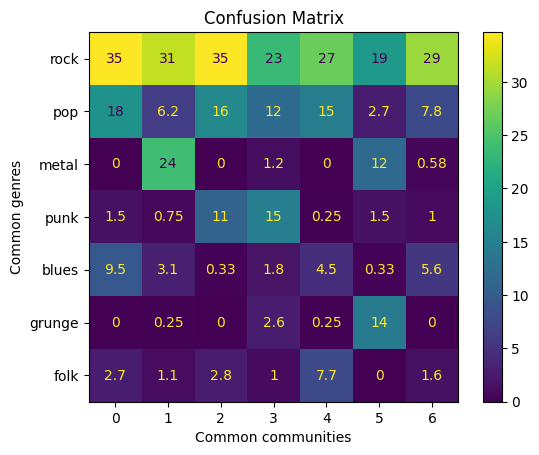

In [6]:
freq_dist = nltk.FreqDist([g for k in performer_genre_dict for g in performer_genre_dict[k]])

c = louvain_communities[0:7]
g = sorted(freq_dist,key=freq_dist.get, reverse=True)[0:len(c)]
d = np.zeros((len(g),len(c)))

for node in performer_genre_dict:
    genres = performer_genre_dict[node]
    j = None
    
    for i,community in enumerate(c):
        if node in community:
            j = i
            break
            
    if j is None:
        continue
        
    same_num = len(set(genres) & set(g))

    if same_num==0:
        continue
    
    for i,genre in enumerate(g):
        if genre in genres:
            d[i,j]+=1/same_num

disp = ConfusionMatrixDisplay(confusion_matrix=d)
disp.plot()
plt.title('Confusion Matrix')
plt.xlabel('Common communities')
plt.ylabel('Common genres')
plt.xticks(range(len(c)),range(0,len(c)))
plt.yticks(range(len(g)),g)
plt.show()

* Plot the communities and comment on your results.
>
>  The result of modularity exhibits a clustering-like effect, with strong structural significance within the communities, which means it reveals hidden network structures. At the same time, the larger the community, the stronger its structure and the more distinct its distribution area.

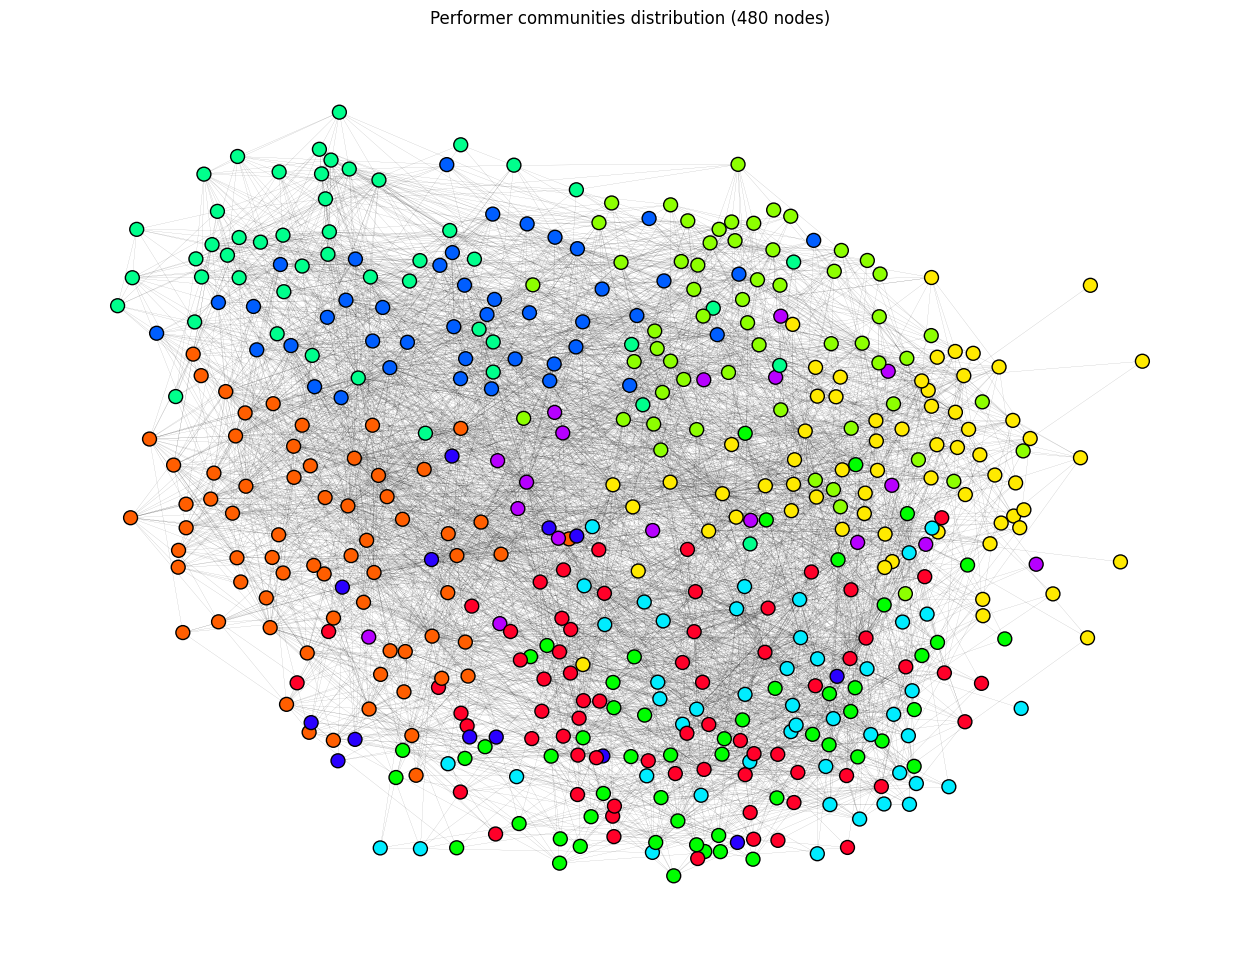

In [7]:
cmap = mpl.colormaps['gist_rainbow']

node_color_list = [cmap(n/len(louvain_communities)) for node in rp_dg_net.nodes for n,community in enumerate(louvain_communities) if node in community]

pos_init = nx.kamada_kawai_layout(rp_ug_net)
pos = nx.forceatlas2_layout(rp_ug_net,pos_init,scaling_ratio=0.9,max_iter=40)

plt.figure(figsize=(16, 12))
plt.title('Performer communities distribution ({} nodes)'.format(len(rp_ug_net.nodes)))
nx.draw(rp_ug_net, pos, node_size=100, node_color=node_color_list, width=0.05, edgecolors="#000000")
plt.show()

# Part 3: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
>
> TF is term frequency, it is the relative frequency of term within document. The term frequency can find frequently occurring words in the document. However, it can not distinguish between high-frequency words that are keywords or meaningless words, such as stop words.
>
> IDF is inverse document frequency, it means the frequency of a word in different documents. It's idea is a word has poor ability to distinguish documents if it in a lot of documents.
>
> A word that can represent a document needs high term frequency and high inverse document frequency, compared with meaningless words which have low inverse document frequency. Based on these concepts, The product of term frequency and inverse document frequency， i.e., TF-IDF value, can help to find the high-frequency keywords in a document. So
>
> So we can find words that have high TF-IDF value in genres and communities as keywords to help the understanding the similarities and difference between them.
>
* Calculate and visualize TF-IDF for the genres and communities.

In [8]:
lemmatizer = WordNetLemmatizer()
def nomarralize_words(text):
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'\<ref\>.*?\<\/ref\>', ' ', text)
    text = re.sub(r'\<ref.*?\>.*?\<\/ref.*?\>', ' ', text)

    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()

    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words]
    return words

def get_clear_freq_dist(text):
    words = nomarralize_words(text)

    freq_dist = nltk.FreqDist(words)
    for w in freq_dist:
        if freq_dist[w] < 5:
            freq_dist.pop(w, None)
    return freq_dist

def get_tf(freq_dist):
    tf_dict = {}
    total = int(np.sum(list(freq_dist.values())))
    max_t = max(freq_dist.values())
    for word in freq_dist:
        tf_dict[word] = 0.5 + 0.5 * freq_dist[word] / max_t
    return tf_dict

def get_idf(document_freq_dist):
    idf_dict = {}
    
    N = len(document_freq_dist)

    for freq_dist in document_freq_dist.values():
        for word in freq_dist:
            n_t = 0

            if word in idf_dict:
                continue

            for document in document_freq_dist.values():
                if word in document:
                    n_t += 1

            idf = math.log(N/n_t)
            idf_dict[word] = idf

    return idf_dict

def get_tf_idf(document_freq_dist,title=None,cols = 3):

    rows = math.ceil(len(document_freq_dist) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    idf_dict = get_idf(document_freq_dist)
    document_tf_idf_dist = {}
    for i, document in enumerate(document_freq_dist):
        tf_dict = get_tf(document_freq_dist[document])
        tf_idf_dist = nltk.FreqDist({w: tf_dict[w] * idf_dict[w] for w in document_freq_dist[document]})
        document_tf_idf_dist[document] = tf_idf_dist
        
        plt.sca(axes[i])
        tf_idf_dist.plot(30, cumulative=False,show=False)
        axes[i].set_title("{}: {}".format(title,document))
        axes[i].set_xlabel("word")
        axes[i].set_ylabel("tf-idf value")

    for j in range(len(document_freq_dist), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    return document_tf_idf_dist

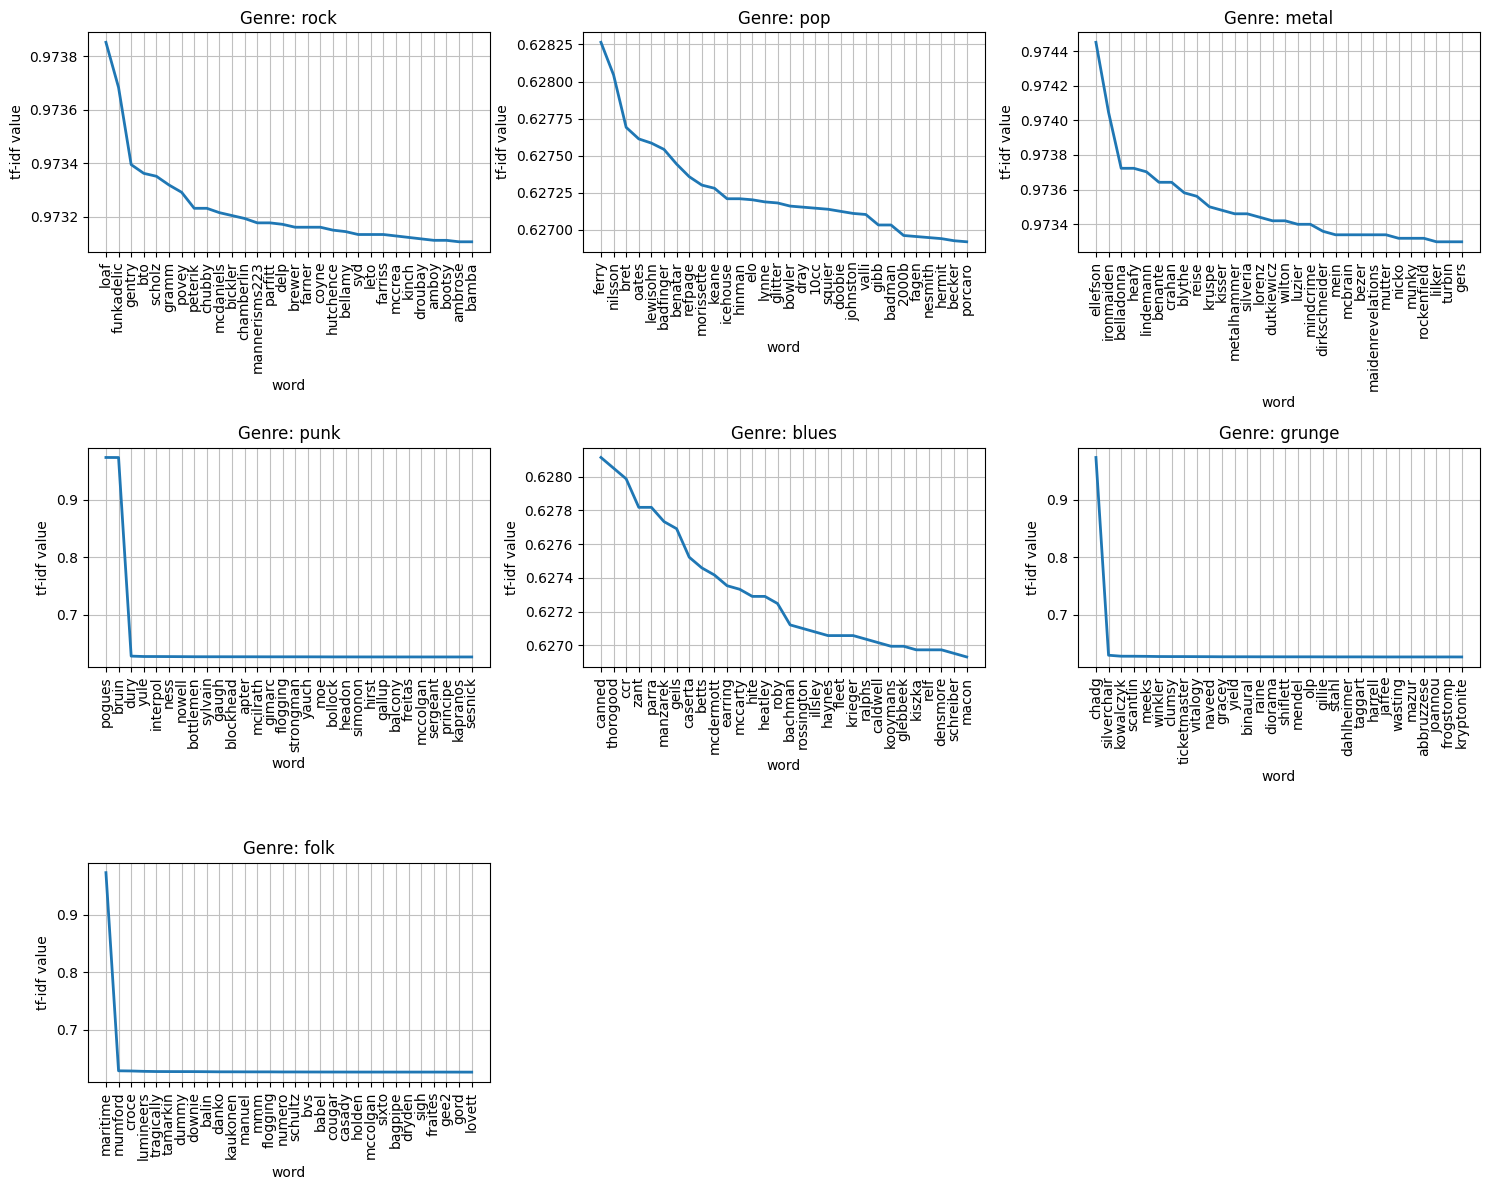

In [9]:
genre_freq_dist = {}
for genre in g:
    text = ""
    for node in performer_genre_dict:
        genres = performer_genre_dict[node]
        
        if genre in genres:
            _,wikitext = wiki_query(node)
            text += wikitext
    genre_freq_dist[genre] = get_clear_freq_dist(text)

genre_tf_idf_dist = get_tf_idf(genre_freq_dist,"Genre")

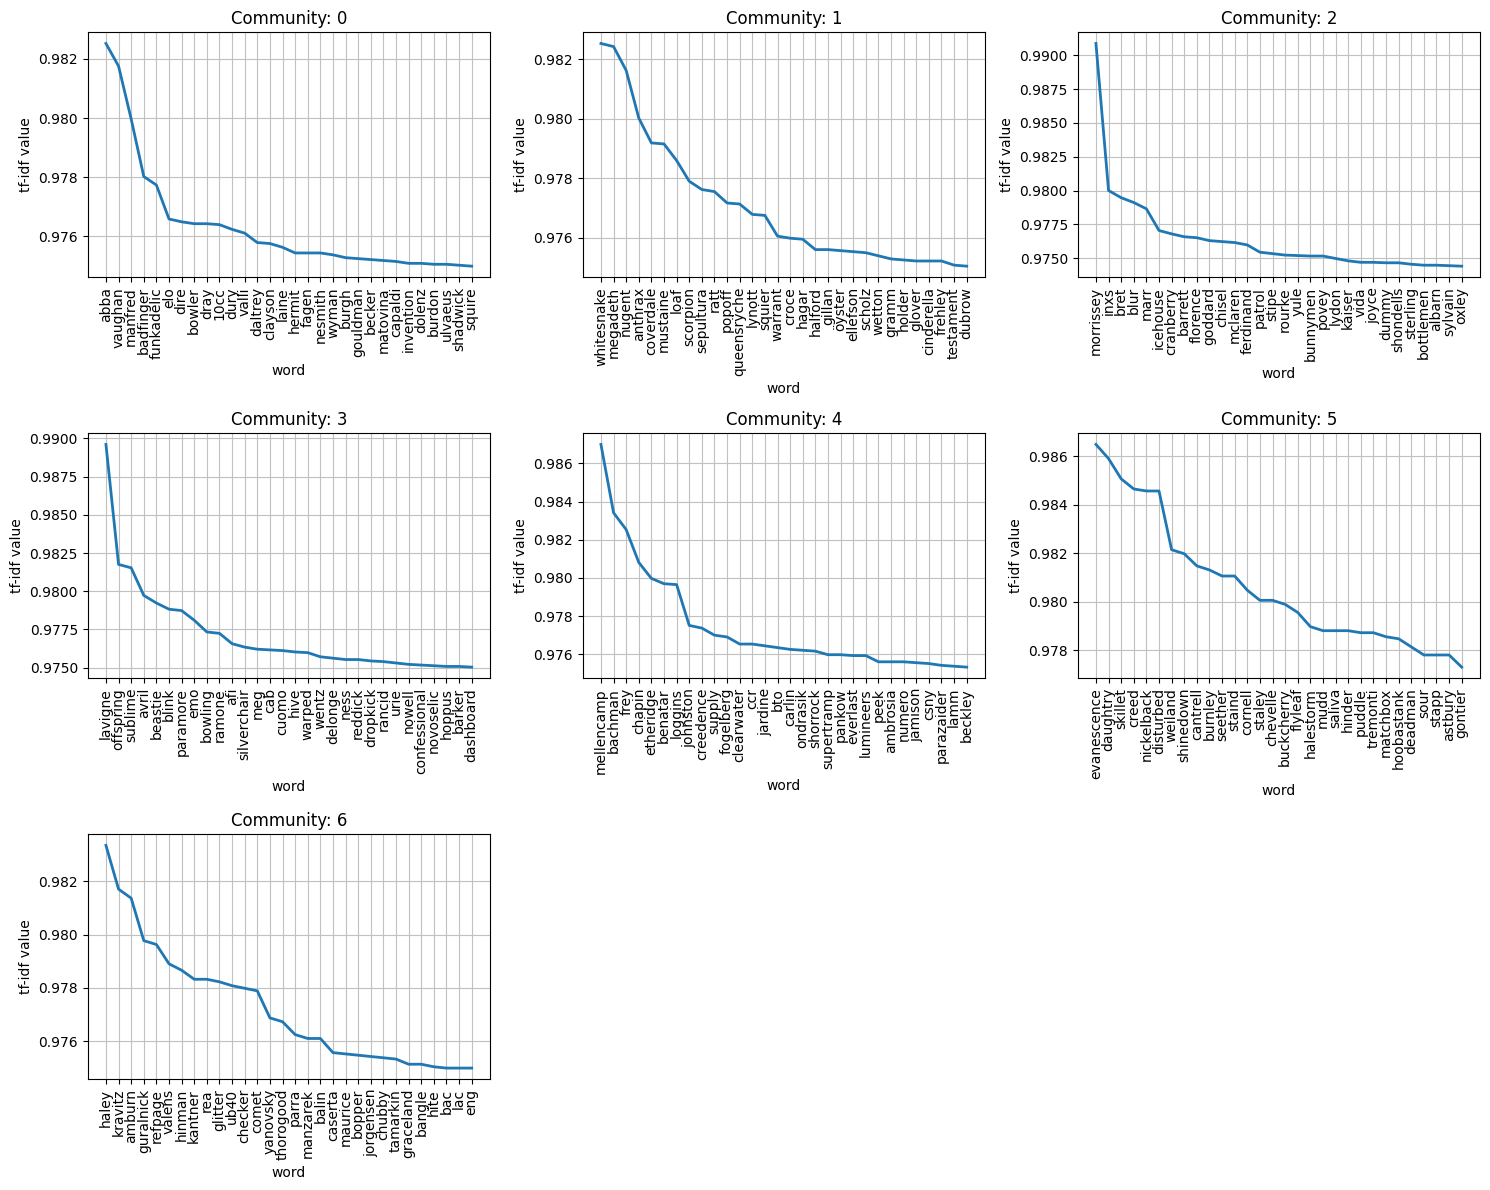

In [10]:
community_freq_dist = {}
for i,community in enumerate(c):
    text = ""
    for node in community:
        _,wikitext = wiki_query(node)
        text += wikitext

    community_freq_dist[i] = get_clear_freq_dist(text)

community_tf_idf_dist = get_tf_idf(community_freq_dist,"Community")

* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.
>
> The matrix D provides a quantitative link between genres and structural communities. Some genres are distributed across multiple communities; conversely, some communities contain multiple genres. The genre word cloud corresponds to the theme of the genre text, while the community word cloud is more mixed, combining keywords from multiple themes. This suggests that structural communities do not reflect pure semantic similarity, but rather a mixture of relationships, such as cross-genre collaboration. This is manifested in matrix D as a multi-peak pattern in the corresponding rows and columns.

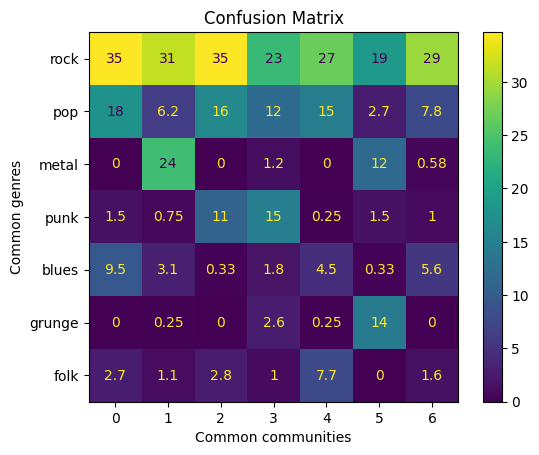

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=d)
disp.plot()
plt.title('Confusion Matrix')
plt.xlabel('Common communities')
plt.ylabel('Common genres')
plt.xticks(range(len(c)),range(0,len(c)))
plt.yticks(range(len(g)),g)
plt.show()

In [12]:
def show_word_clouds(document_tf_idf_dist,title=None,cols = 3):

    rows = math.ceil(len(document_tf_idf_dist) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, document in enumerate(document_tf_idf_dist):
        tf_idf_dist = document_tf_idf_dist[document]
        tf_idf_dict_values = set(tf_idf_dist.values())
        tf_idf_dict_values.remove(0)
        min_tf_idf = min(tf_idf_dict_values)

        tf_idf_text = " ".join([word for word, tf_idf in tf_idf_dist.items() for _ in range(round(tf_idf/min_tf_idf)+1)])
        document_wc = WordCloud(width=800, height=400, background_color='white',collocations=False).generate(tf_idf_text)
        axes[i].imshow(document_wc)
        axes[i].set_title("{}: {} word-cloud".format(title,document))

    for j in range(len(document_tf_idf_dist), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

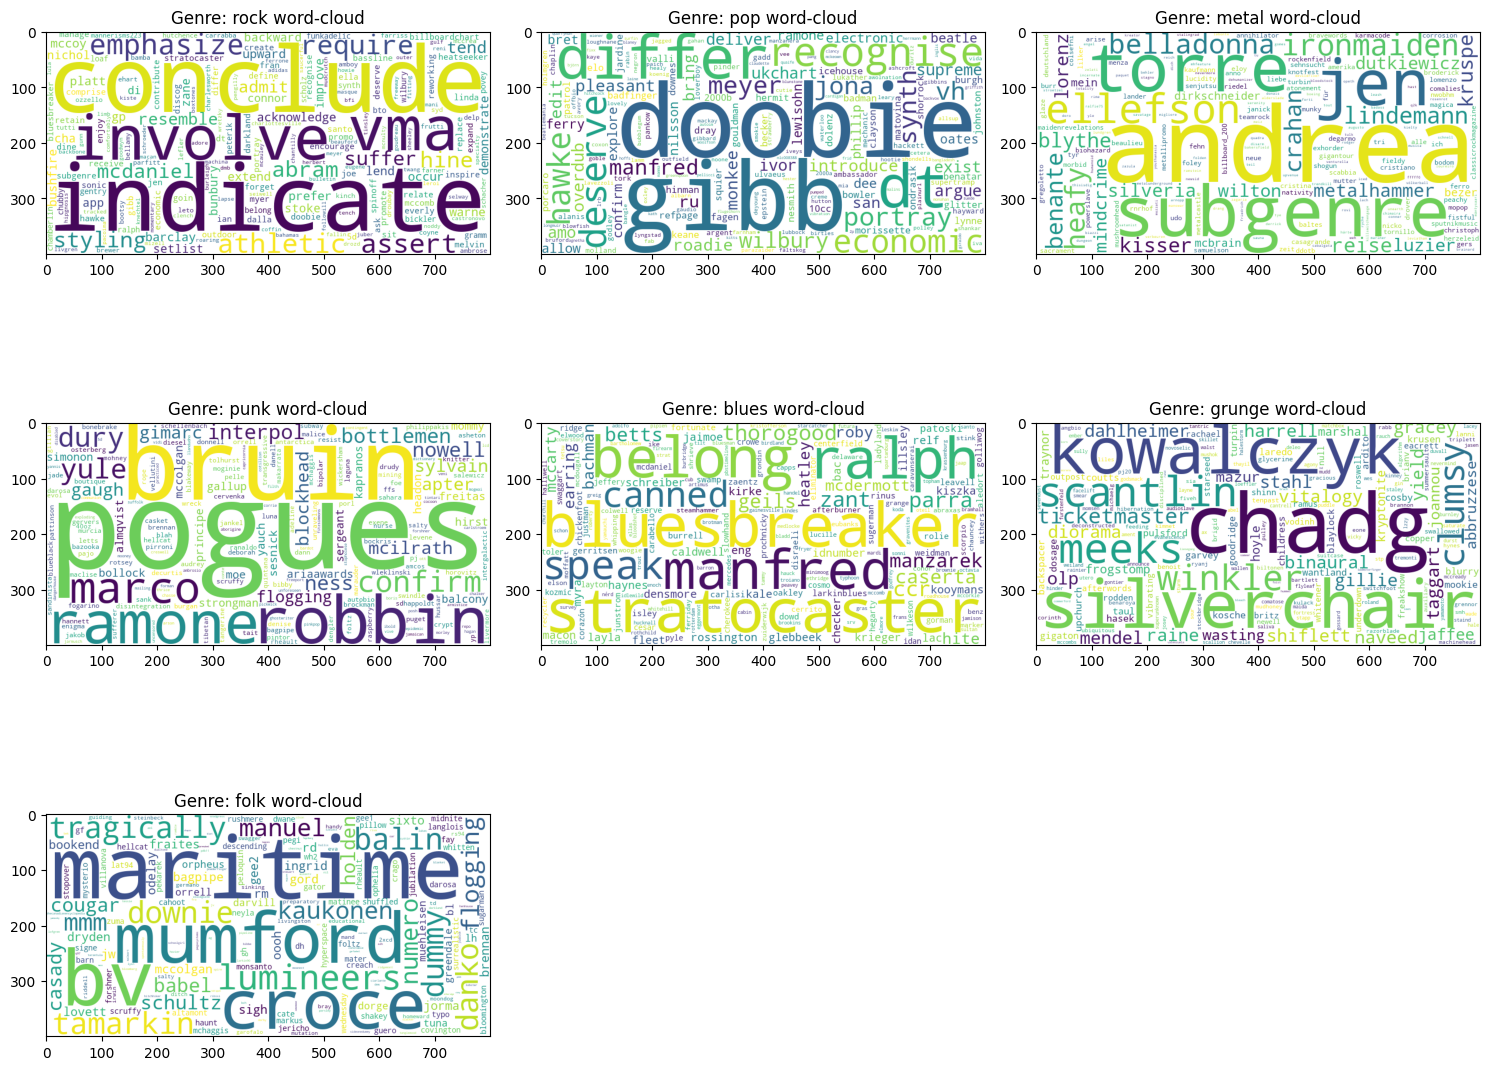

In [13]:
show_word_clouds(genre_tf_idf_dist,"Genre")

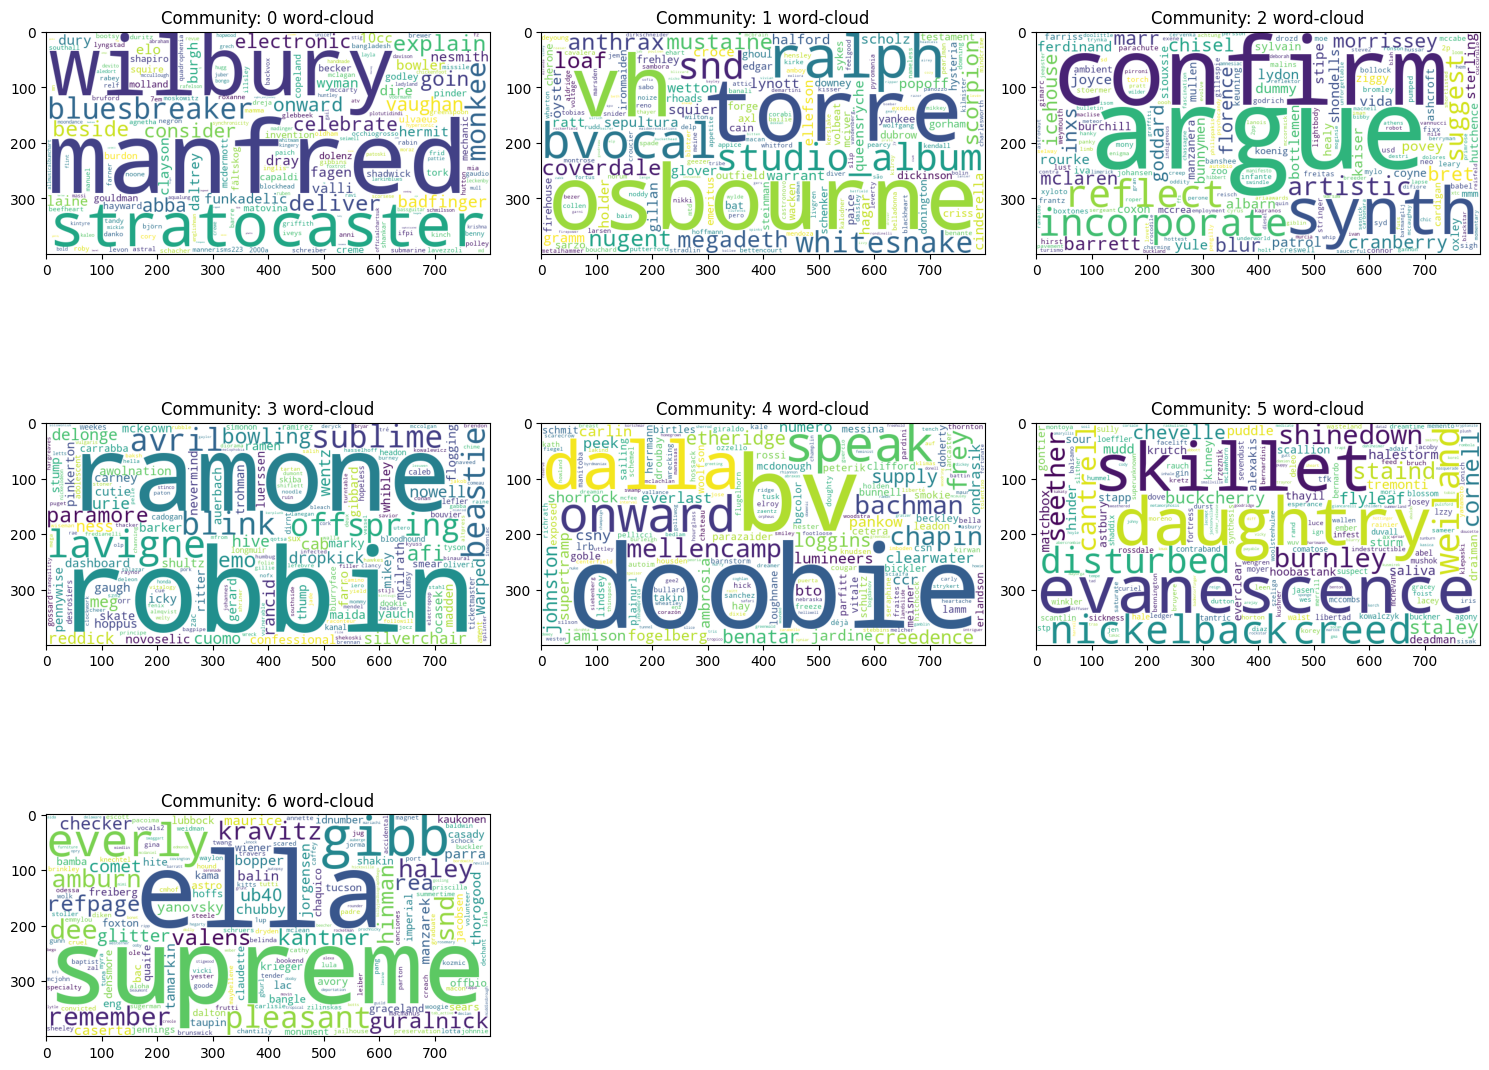

In [14]:
show_word_clouds(community_tf_idf_dist,"Community")

# Part 4: Sentiment of the artists and communities

In [15]:
s1_url = "https://www.student.dtu.dk/~s230357/02805/assignment2/labMT-english.csv"

s1_dataset = pd.read_csv(BytesIO(load_online_data(s1_url)))
labmt_dict = dict(zip(s1_dataset['word'], s1_dataset['sentiment']))

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
>
> I found that most wikipedia pages have neutral emotion and a bit more positive, the median, 25th percentile and 75th percentile illustrates this point. I think the main reason is wikipedia needs to maintain an objective stance and avoid being overly emotional or misleading to readers.

Top 10 happiest artists: ['Tracy_Chapman', 'Lenny_Kravitz', 'Michael_Martin_Murphey', 'Edgar_Winter', 'The_Cardigans', 'Boys_Like_Girls', 'Kenny_Loggins', 'The_Boxtones', 'Fun_(band)', 'Kaiser_Chiefs']
Top 10 saddest artists: ['Five_Finger_Death_Punch', 'Pantera', 'W.A.S.P._(band)', 'Skid_Row_(American_band)', 'Ted_Nugent', 'Rob_Zombie', 'Marilyn_Manson', 'Canned_Heat', 'Gary_Glitter', 'Rage_Against_the_Machine']


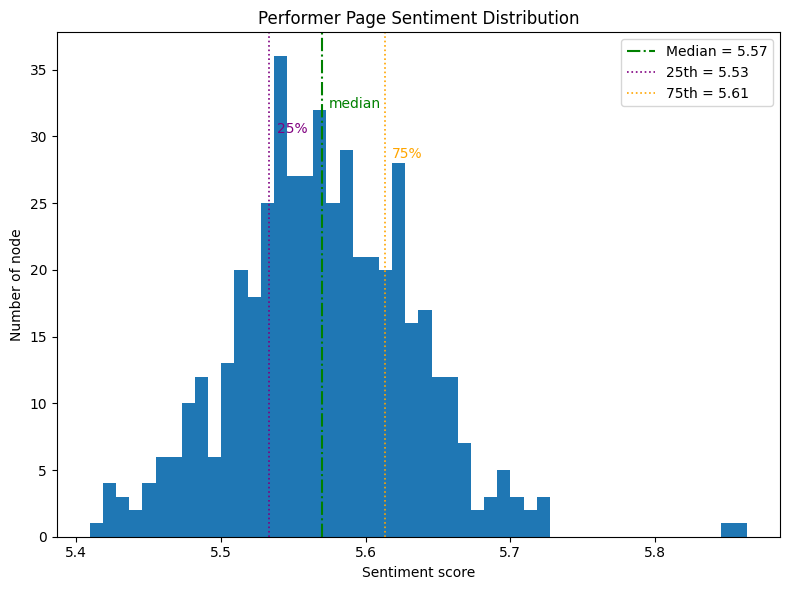

In [21]:
def get_sentiment(text):
    words = nomarralize_words(text)
    sentiments = [labmt_dict[w] for w in words if w in labmt_dict]
    return float(np.mean(sentiments))

artist_sentiment_dict = {node:get_sentiment(wiki_query(node)[1]) for node in rp_ug_net.nodes}

nx.set_node_attributes(rp_ug_net, {node:{"sentiment":artist_sentiment_dict[node]} for node in rp_ug_net.nodes})

sorted_artist_sentiments = sorted(artist_sentiment_dict,key=artist_sentiment_dict.get, reverse=True)

print("Top 10 happiest artists: {}".format(sorted_artist_sentiments[0:10]))
print("Top 10 saddest artists: {}".format(sorted_artist_sentiments[-10:]))

median = np.median(list(artist_sentiment_dict.values()))
variance = np.var(list(artist_sentiment_dict.values()))
p25 = np.percentile(list(artist_sentiment_dict.values()), 25)
p75 = np.percentile(list(artist_sentiment_dict.values()), 75)

plt.figure(figsize=(8, 6))
plt.hist(artist_sentiment_dict.values(), bins=50)

plt.title("Performer Page Sentiment Distribution")
plt.xlabel("Sentiment score")
plt.ylabel("Number of node")

plt.axvline(median, color='green', linestyle='-.', linewidth=1.5, label=f'Median = {median:.2f}')
plt.axvline(p25, color='purple', linestyle=':', linewidth=1.2, label=f'25th = {p25:.2f}')
plt.axvline(p75, color='orange', linestyle=':', linewidth=1.2, label=f'75th = {p75:.2f}')

plt.text(median+0.005, plt.ylim()[1]*0.85, 'median', color='green')
plt.text(p25+0.005, plt.ylim()[1]*0.8, '25%', color='purple')
plt.text(p75+0.005, plt.ylim()[1]*0.75, '75%', color='orange')

plt.legend()
plt.tight_layout()
plt.show()

* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?
> Overall, there was very little variation in sentiment across the communties, I think primarily due to the fact that wikipedia pages are meant to be written in a neutral tone. I used TF-IDF value to weight the communty sentiment calculation, because of the differet value between words, the weighted communty sentiment lower a little bit with the unweighted one, but the overall changes was not significant.

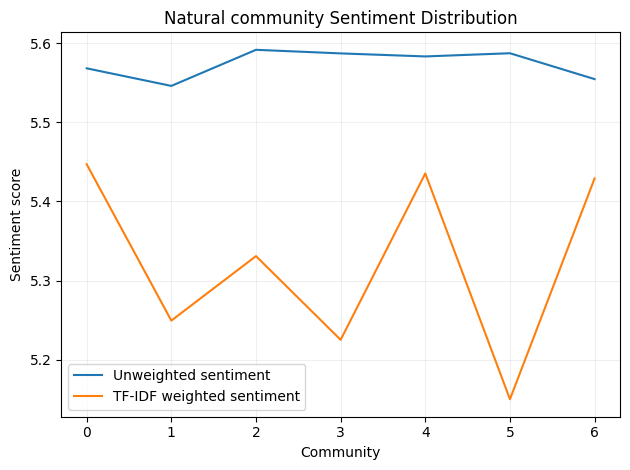

In [17]:
community_normal_sentiment = []

for community in c:
    community_normal_sentiment.append(float(np.mean([s for n,s in rp_ug_net.nodes.data('sentiment') if n in community])))
    
community_tf_idf_sentiment = []

for i,community in enumerate(c):
    tf_idf_dist = community_tf_idf_dist[i]
    avg_tf_idf = np.mean([tf_idf_dist[w] for w in tf_idf_dist if w in labmt_dict])
    community_tf_idf_sentiment.append(float(np.mean([tf_idf_dist[w]*labmt_dict[w] for w in tf_idf_dist if w in labmt_dict])/avg_tf_idf))

plt.plot(range(len(community_normal_sentiment)),community_normal_sentiment,label="Unweighted sentiment")
plt.plot(range(len(community_tf_idf_sentiment)),community_tf_idf_sentiment,label="TF-IDF weighted sentiment")
plt.title('Natural Community Sentiment Distribution')
plt.xlabel('Community')
plt.ylabel('Sentiment score')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
    
plt.tight_layout()
plt.show()